This is the notebook to plot the results deriving from empirical data, namely the demographics, WMH frequency maps (Fig. 3A), the distribution of the phFCD (Fig. 3B) and the correlation between wmh, tau and amyloid (Suppl. Fig. 3).

In [1]:
import templateflow.api as tf
from petTOAD_load import *
from petTOAD_analyses_helpers import *
from scipy.stats import ks_2samp, mannwhitneyu

TBL_DIR = RES_DIR / "Tables"
if not Path.exists(TBL_DIR):
    Path.mkdir(TBL_DIR)


cmap = cm.RdYlBu_r
tick_fontsize = 7

In [2]:
# Load the subjects df
df_petTOAD = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col = 0)
df_petTOAD["WMH_bin"] = np.where(
    df_petTOAD["Group_bin_Fazekas"].str.contains("no_WMH"), "no_WMH", "WMH"
)
df_petTOAD["wmh_log"] = np.log10(
    df_petTOAD["WMH_load_subj_space"],
    where=(df_petTOAD["WMH_load_subj_space"] != 0),
    out=np.zeros_like(df_petTOAD["WMH_load_subj_space"]),
)
df_petTOAD["Acq Date"] = pd.to_datetime(df_petTOAD["Acq Date"])
# Load the df with amyloid and tau data and polish
df_amy_tau = pd.read_csv(UTL_DIR / "UPENNBIOMK_MASTER_FINAL_31Jan2024.csv")
df_amy_tau["PTID"] = "ADNI" + df_amy_tau["PTID"].str.replace("_","")
df_amy_tau["DRAWDATE"] = pd.to_datetime(df_amy_tau["EXAMDATE"])
# Merge based on 'RID' and date condition. Select a window of 6 months to be considered the same timepoint.
merged_df = pd.merge(df_petTOAD, df_amy_tau, on="PTID")
merged_df = merged_df[
    (merged_df["DRAWDATE"] >= merged_df["Acq Date"] - pd.DateOffset(months=3)) &
    (merged_df["DRAWDATE"] <= merged_df["Acq Date"] + pd.DateOffset(months=3))
]

merged_df["ABETA40"] = pd.to_numeric(merged_df["ABETA40"])
merged_df["ABETA42"] = pd.to_numeric(merged_df["ABETA42"])
merged_df["TAU"] = pd.to_numeric(merged_df["TAU"])
merged_df["ABETA_ratio"] = merged_df["ABETA42"]/merged_df["ABETA40"]

In [3]:
create_table_demographics(df_petTOAD)

,no WMH (n = 100),WMH (n = 88),p
Age,69.0 (65.75 - 73.0),75.0 (69.0 - 79.0),< 0.001
Sex n (%),,,0.51
Women,51 (51.0%),50 (56.82%),
Men,49 (49.0%),38 (43.18%),
WMH vol. (log),3.36 (3.02 - 3.59),4.11 (3.82 - 4.38),< 0.001
MMSE,29.0 (28.0 - 30.0),29.0 (27.0 - 30.0),0.864
Education (yrs.),17.0 (15.75 - 18.0),16.0 (14.75 - 18.0),0.158


/home/leoner/Projects/petTOAD/scripts/TMS_in_AD/03_modeling_neurolib/petTOAD_analyses_helpers.py:725: RuntimeWarning: All-NaN slice encountered
  np.rot90(np.nanmax(wmh_rev, axis=0)), cmap="RdYlBu_r", vmin=0.0, vmax=1
/home/leoner/Projects/petTOAD/scripts/TMS_in_AD/03_modeling_neurolib/petTOAD_analyses_helpers.py:728: RuntimeWarning: All-NaN slice encountered
  np.rot90(np.nanmax(wmh_rev, axis=1)), cmap="RdYlBu_r", vmin=0.0, vmax=1
/home/leoner/Projects/petTOAD/scripts/TMS_in_AD/03_modeling_neurolib/petTOAD_analyses_helpers.py:731: RuntimeWarning: All-NaN slice encountered
  np.rot90(np.nanmax(wmh_rev, axis=2)), cmap="RdYlBu_r", vmin=0.0, vmax=1


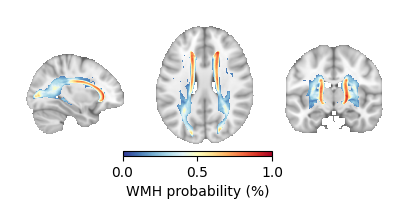

In [4]:
# Calculate average maps for each group
wmh_avg_map = calculate_group_avg_wmh_map(df_petTOAD)
# Load the MNI T1 for plotting
t1_filename = tf.get(template="MNI152NLin6Asym", suffix="T1w", desc="brain", resolution="01")
t1 = nib.load(t1_filename)
# Get the data
t1_ax = t1.get_fdata()
# Change the zeros to nans for masking what is not brain
t1_ax_rev = np.where(t1_ax == 0, np.nan, t1_ax)
# we don't show the voxels with WMH in less than 10% of the people to avoid showing also possible artifacts
wmh_rev = np.where(wmh_avg_map.get_fdata() < 0.1, np.nan, wmh_avg_map.get_fdata())

list_positions_first_row = [0.35, 0.22, 0.3, 0.02]

fig, axs = plt.subplots(1, 3, figsize = (5, 2.5))
plot_t1_wmh_mask(axs[:], t1_ax_rev, wmh_rev)
plot_colorbar_ax(fig, cmap, list_positions_first_row)
fig.subplots_adjust(wspace=0., hspace=0)
fig.savefig(FIG_DIR / "wmh_map_fig3a.png", dpi = 500)

In [5]:
# Calculate the phfcd
phfcd_no_wmh = calculate_group_phfcd(df_petTOAD, "no_WMH")
phfcd_wmh = calculate_group_phfcd(df_petTOAD, "WMH")
# Calculate the distance between the distributions
ksd_all, p_ksd_all = ks_2samp(phfcd_no_wmh.mean(axis=0), phfcd_wmh.mean(axis=0))
# Format the pvalue for the figure
p_ksd_all = format_pval(p_ksd_all)
# Now we plot the distributions of the phFCD in different groups according to the presence/absence of WMH
fig, ax = plt.subplots(1, figsize=(2.05, 2.2), constrained_layout=True)
ax.hist(phfcd_no_wmh.mean(axis=0), bins=200, alpha = 0.5, label = "No WMH")
ax.hist(phfcd_wmh.mean(axis=0), bins=200, alpha = 0.5, label = "WMH")
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax.set_xlabel("phFCD", fontsize = tick_fontsize + 2)
ax.set_title("Distribution of phFCD",fontsize = 10)
ax.text(0.7, 0.3, f'{ksd_all:.2f}, {p_ksd_all}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=tick_fontsize)
ax.legend(fontsize=8, title_fontsize=10)
fig.savefig(FIG_DIR / "phfcd_distribution_fig3b.png", dpi = 500)

  0%|          | 0/100 [00:00<?, ?it/s]

 74%|███████▍  | 74/100 [00:41<00:14,  1.85it/s]

Data available for 101 subjects 66 CU and 35 MCI


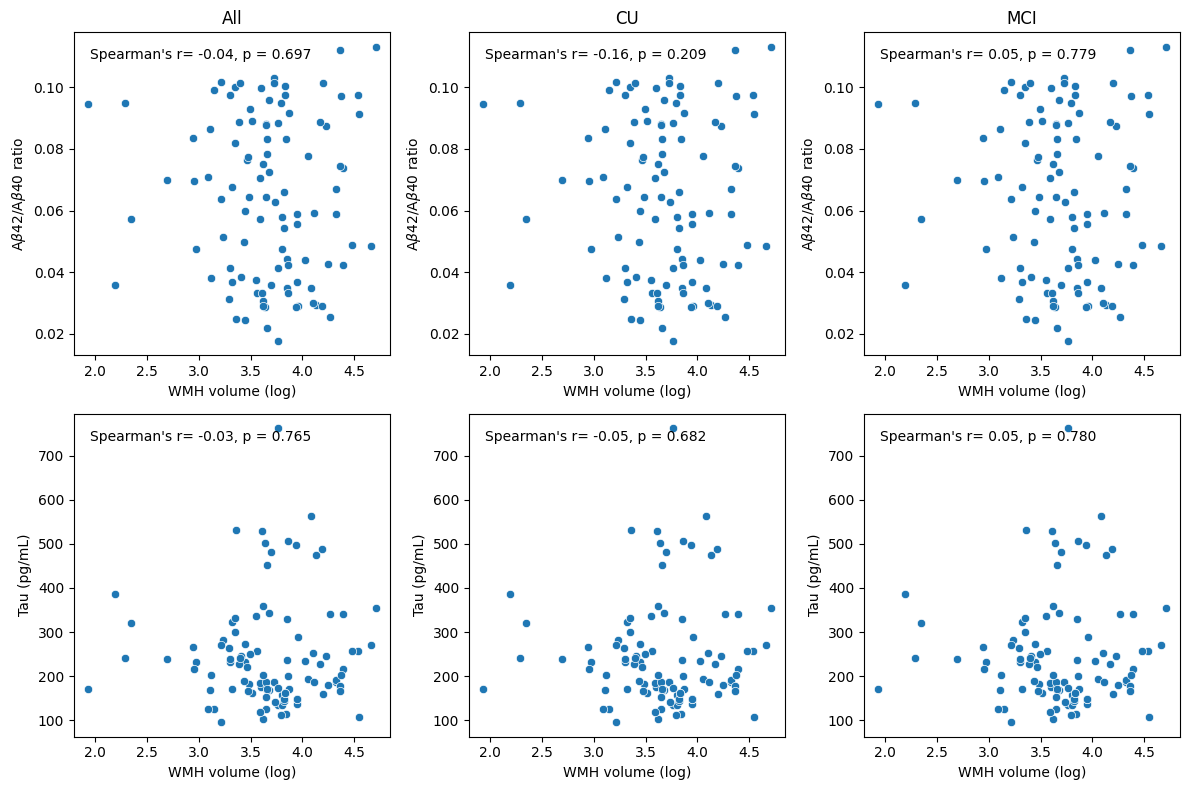

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 8))
plot_wmh_bmrks(merged_df, "All", axs[:, 0])
plot_wmh_bmrks(merged_df, "CN", axs[:, 1])
plot_wmh_bmrks(merged_df, "MCI", axs[:, 2])
fig.tight_layout()
fig.savefig(FIG_DIR / "suppl_fig3_wmh_tau_amy_corrplot.png", dpi = 500)
print("Data available for", merged_df.shape[0], "subjects", merged_df[merged_df["Group"] == "CN"].shape[0], "CU and", merged_df[merged_df["Group"] == "MCI"].shape[0], "MCI")